## Main process

In [1]:
import os, glob
import numpy as np
import pandas as pd

ORIGIN = "Origin/origin.csv" 
ALL_DIR = "All"                

def load_origin(path):
    df = pd.read_csv(path, header=None, usecols=[0, 1], names=["query", "baseline_ms"])
    df["query"] = df["query"].astype(str).str.strip()
    df["baseline_ms"] = pd.to_numeric(df["baseline_ms"], errors="coerce")
    df = df[np.isfinite(df["baseline_ms"]) & (df["baseline_ms"] > 0)]
    return df

def find_csv_for_query(q):
    candidates = [
        os.path.join(ALL_DIR, f"{q}.csv"),
        os.path.join(ALL_DIR, f"{q}.CSV"),
    ]
    for p in candidates:
        if os.path.exists(p): return p
    for pat in [os.path.join(ALL_DIR, f"{q}*.csv"),
                os.path.join(ALL_DIR, f"{q}*.CSV")]:
        got = glob.glob(pat)
        if got: return got[0]
    return None

def read_times_second_col(path):
    col = pd.read_csv(path, header=None, usecols=[1]).iloc[:, 0]
    col = pd.to_numeric(col, errors="coerce")
    col = col[np.isfinite(col) & (col > 0)]
    return col

def main():
    origin = load_origin(ORIGIN)

    rows, missing = [], []
    for _, r in origin.iterrows():
        q = r["query"]; base = float(r["baseline_ms"])
        f = find_csv_for_query(q)
        if not f:
            missing.append(q)
            rows.append({
                "query": q, "baseline_ms": base,
                "min_ms": np.nan, "max_ms": np.nan,
                "faster": False, "speedup": np.nan,
                "best_row": np.nan, "worst_row": np.nan,
                "file": None,
                "regret_spark": np.nan,          
                "regret_pct": np.nan           
            })
            continue

        times = read_times_second_col(f)
        if len(times) == 0:
            rows.append({
                "query": q, "baseline_ms": base,
                "min_ms": np.nan, "max_ms": np.nan,
                "faster": False, "speedup": np.nan,
                "best_row": np.nan, "worst_row": np.nan,
                "file": f,
                "regret_spark": np.nan,          
                "regret_pct": np.nan             
            })
            continue

        # Fastest / Slowest
        min_idx = int(times.idxmin())
        min_ms  = float(times.loc[min_idx])
        max_idx = int(times.idxmax())
        max_ms  = float(times.loc[max_idx])

        faster  = (min_ms < base)
        speedup = (base / min_ms) if np.isfinite(min_ms) and min_ms > 0 else np.nan

        # regret: The multiple of native Spark relative to the optimal combination
        
        regret = (base / min_ms) if (np.isfinite(min_ms) and min_ms > 0) else np.nan
        regret_pct = (regret - 1.0) * 100.0 if np.isfinite(regret) else np.nan

        rows.append({
            "query": q,
            "baseline_ms": base,
            "min_ms": min_ms,
            "max_ms": max_ms,
            "faster": faster,
            "speedup": speedup,
            "best_row": min_idx + 1,   # 1-based
            "worst_row": max_idx + 1, 
            "file": f,
            "regret_spark": regret,    
            "regret_pct": regret_pct   
        })

    report = pd.DataFrame(rows)
    # Sorting
    report = report.sort_values(
        by=["faster", "regret_spark", "speedup"],
        ascending=[False, True, False]
    )
    report.to_csv("report.csv", index=False)

    # Statistical Summary
    matched = report[report["min_ms"].notna()].copy()
    num_total   = len(origin)
    num_found   = len(matched)
    num_improve = int(matched["faster"].sum())
    ratio       = (num_improve / num_found) if num_found else 0.0

    print(f"Total queries: {num_total}")
    print(f"Successfully matched the number of queries for All/* files: {num_found}")
    print(f"There are faster combinations of queries: {num_improve} (proportion {ratio:.1%})")

    # regret summary
    valid_regret = matched["regret_spark"].replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid_regret) > 0:
        med_rg = float(np.median(valid_regret))
        mean_rg = float(np.mean(valid_regret))
        succ10 = float(np.mean(valid_regret <= 1.10))
        succ20 = float(np.mean(valid_regret <= 1.20))
        print(f"\n[Baseline vs Best] Regret(median)={med_rg:.3f}×  Regret(mean)={mean_rg:.3f}×")
        print(f"[Baseline vs Best] Success@10%={succ10:.1%}  Success@20%={succ20:.1%}")
    else:
        print("\n[Baseline vs Best] No valid regret data.")

    # Examples showcasing some of the most notable improvements
    improved = report[report["faster"]].head(10)
    print("\nSample (the 10 most obvious accelerations):")
    for _, r in improved.iterrows():
        print(f"- {r['query']}: baseline={r['baseline_ms']:.0f} ms, "
              f"best={r['min_ms']:.0f} ms, speedup={r['speedup']:.2f}×, "
              f"regret={r['regret_spark']:.3f}×, "
              f"file={os.path.basename(r['file']) if pd.notna(r['file']) else 'NA'}, "
              f"best_row={int(r['best_row']) if pd.notna(r['best_row']) else -1}")

if __name__ == "__main__":
    main()


Total queries: 103
Successfully matched the number of queries for All/* files: 103
There are faster combinations of queries: 81 (proportion 78.6%)

[Baseline vs Best] Regret(median)=1.189×  Regret(mean)=2.134×
[Baseline vs Best] Success@10%=34.0%  Success@20%=51.5%

Sample (the 10 most obvious accelerations):
- q39a: baseline=5888 ms, best=5834 ms, speedup=1.01×, regret=1.009×, file=q39a.csv, best_row=3
- q8: baseline=2454 ms, best=2390 ms, speedup=1.03×, regret=1.027×, file=q8.csv, best_row=6
- q62: baseline=2344 ms, best=2280 ms, speedup=1.03×, regret=1.028×, file=q62.csv, best_row=6
- q33: baseline=2673 ms, best=2566 ms, speedup=1.04×, regret=1.042×, file=q33.csv, best_row=3
- q3: baseline=1896 ms, best=1818 ms, speedup=1.04×, regret=1.043×, file=q3.csv, best_row=3
- q57: baseline=16480 ms, best=15492 ms, speedup=1.06×, regret=1.064×, file=q57.csv, best_row=3
- q83: baseline=12572 ms, best=11800 ms, speedup=1.07×, regret=1.065×, file=q83.csv, best_row=3
- q7: baseline=5829 ms, best=

## Visualization

Total queries: 103
Successfully matched the number of queries for All/* files: 103
There are faster combinations of queries: 81 (proportion 78.6%)

[Baseline vs Best] Regret(median)=1.189×  Regret(mean)=2.134×
[Baseline vs Best] Success@10%=34.0%  Success@20%=51.5%

Sample (the 10 most obvious accelerations):
- q39a: baseline=5888 ms, best=5834 ms, speedup=1.01×, regret=1.009×, file=q39a.csv, best_row=3
- q8: baseline=2454 ms, best=2390 ms, speedup=1.03×, regret=1.027×, file=q8.csv, best_row=6
- q62: baseline=2344 ms, best=2280 ms, speedup=1.03×, regret=1.028×, file=q62.csv, best_row=6
- q33: baseline=2673 ms, best=2566 ms, speedup=1.04×, regret=1.042×, file=q33.csv, best_row=3
- q3: baseline=1896 ms, best=1818 ms, speedup=1.04×, regret=1.043×, file=q3.csv, best_row=3
- q57: baseline=16480 ms, best=15492 ms, speedup=1.06×, regret=1.064×, file=q57.csv, best_row=3
- q83: baseline=12572 ms, best=11800 ms, speedup=1.07×, regret=1.065×, file=q83.csv, best_row=3
- q7: baseline=5829 ms, best=

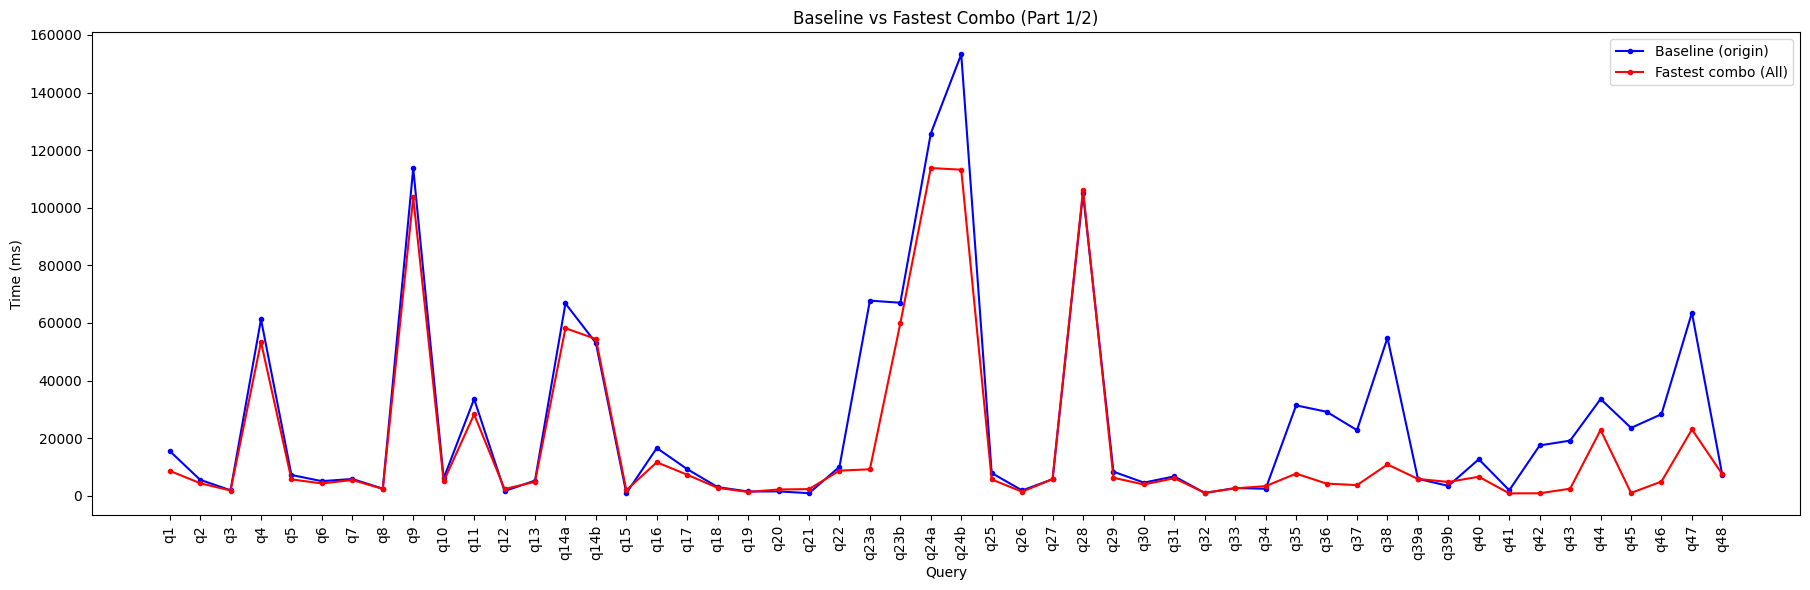

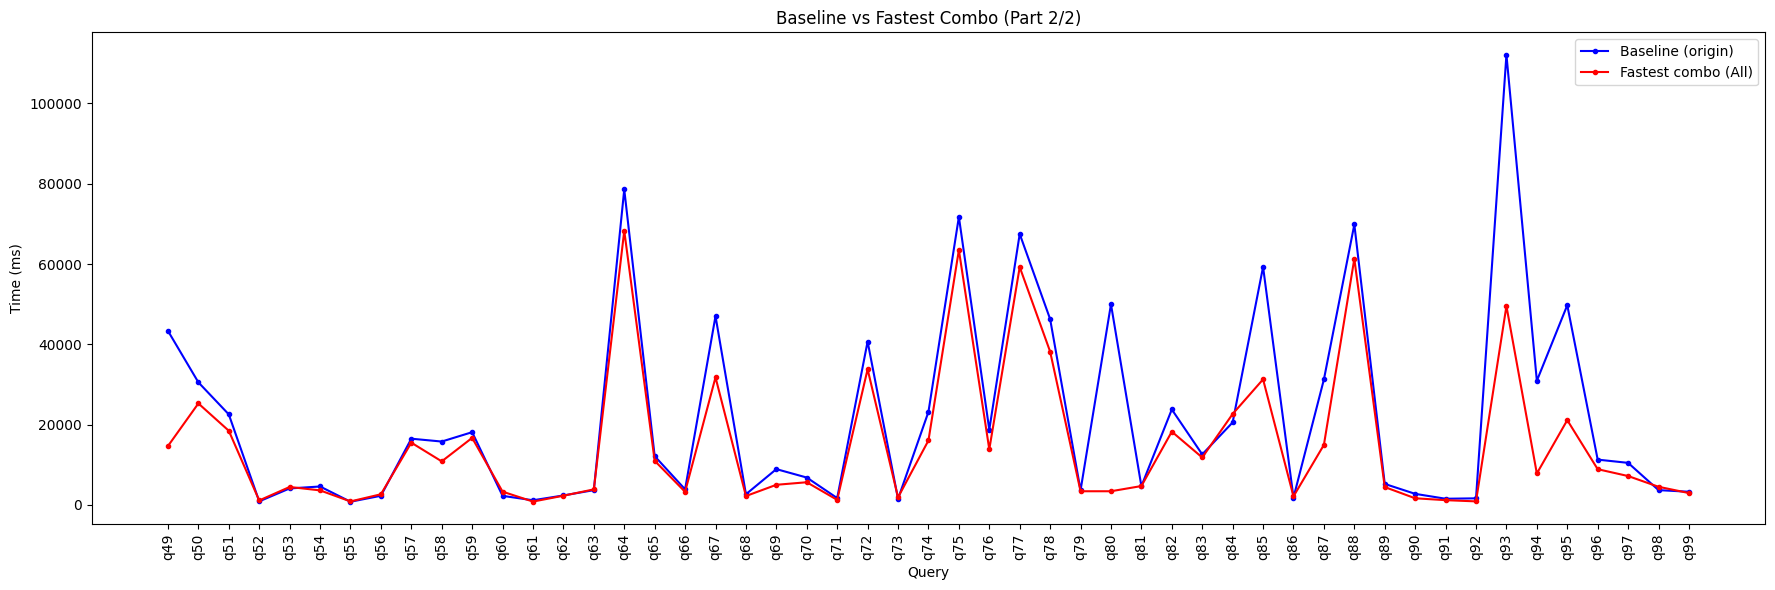

In [3]:
def plot_from_report():
    import pandas as pd, matplotlib.pyplot as plt, re
    from math import ceil
    report = pd.read_csv("report.csv")

    def natkey(s):
        return tuple(int(x) if x.isdigit() else x
                     for x in re.findall(r'\d+|\D+', str(s)))

    plot_df = report.sort_values("query", key=lambda s: s.map(natkey)).reset_index(drop=True)
    n = len(plot_df)
    mid = ceil(n / 2)

    def make_plot(df_slice, outfile, title):
        import matplotlib.pyplot as plt
        L = len(df_slice)
        plt.figure(figsize=(min(max(10, L * 0.35), 32), 6))
        plt.plot(df_slice["query"], df_slice["baseline_ms"],
                 "-o", label="Baseline (origin)", color="blue", linewidth=1.5, markersize=3)
        plt.plot(df_slice["query"], df_slice["min_ms"],
                 "-o", label="Fastest combo (All)", color="red", linewidth=1.5, markersize=3)
        plt.xticks(rotation=90)
        plt.xlabel("Query"); plt.ylabel("Time (ms)")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.savefig(outfile, dpi=200)
        print(f"Saved line chart -> {outfile}")

    
    make_plot(plot_df.iloc[:mid], "cbo_compare_part1.png", "Baseline vs Fastest Combo (Part 1/2)")
    make_plot(plot_df.iloc[mid:], "cbo_compare_part2.png", "Baseline vs Fastest Combo (Part 2/2)")


if __name__ == "__main__":
    main()
    plot_from_report()
